In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from gurobipy import GRB, Model, quicksum, Column

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Plotting frame
plt.rcParams["figure.figsize"] = (7, 7)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

#### _____
### Multi-Depot Constrained Vehicle Routing Function

In [2]:
def MDCVRP(cust_x, cust_y, cust_demand, depot_x, depot_y, vehicles, veh_depot, veh_capacity, time_lim):
    """
    
    Parameters
    ----------
    cust_x : Integer Arrary
        Array containing x-coordinates of customers.
    
    cust_y : Integer Arrary
        Array containing y-coordinates of customers.
    
    cust_demand : Integer Arrary
        Array containing cuulative demand of each customer.
    
    depot_x : Integer Arrary
        Array containing x-coordinates of depots.
    
    depot_y : Integer Arrary
        Array containing y-coordinates of depots.
    
    vehicles : Integer Arrary
        Array containing numbered vehicles alloted to passed 
        depots.
    
    veh_depot : Integer Arrary
        Array containing depot allocations to corresponding 
        vehicles.
    
    veh_capacity : Integer Arrary
        Array containing maximum load capacity corresponding to 
        each vehicles.
    
    time_lim : Integer
        The maximum time limit upto which the optimization model 
        will work.
    
    Returns
    -------
    routes: Array
        Array of all vehicle routes
        
    veh_routes: Array
        List of vehicles associated with each routes in routes
    
    depot_routes: 
        List of depots associated with each route in routes
    
    X: Array
        List of x coordinates for all nodes
    
    Y: Array
        List of y coordinates for all nodes
    
    depot: Array
        List of depot nodes linked with X and Y
        
    obj_val: Integer
        The final objective value of model
      
    """
    
    n, m = len(cust_x), len(depot_x)
    customer = [i for i in range(n)]
    depot = [i for i in range(n, m+n)]
    nodes = [i for i in range(m+n)]
    veh_depot = np.array(veh_depot) + n
    
    q = {i: cust_demand[i] for i in customer}
    for i in depot:
        q[i] = 0
    Q = veh_capacity
        
    X = list(cust_x) + list(depot_x)
    Y = list(cust_y) + list(depot_y)
    
    distance = {(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodes 
                for j in nodes if i!=j}
    arcs = [(i,j) for i in nodes for j in nodes if i!=j]
    arcs_vehicle = [(i,j,k) for i in nodes for j in nodes                      # constructing arcs between all points
                    for k in vehicles if i!=j]

    # MDCVRP Model
    model = Model('MDCVRP')
    x = model.addVars(arcs_vehicle,vtype=GRB.BINARY,name='x')                  # Binary Decision Variable
    u = model.addVars(customer, vtype=GRB.CONTINUOUS, name='u')
    
    model.setObjective(quicksum(distance[i,j]*x[i,j,k]                         # setting model objective
                                for i,j,k in arcs_vehicle), GRB.MINIMIZE)
    model.addConstrs(quicksum(x[i,j,k] for i in nodes                          # each node visited by only one vehicle
                              for k in vehicles if i!=j)==1 for j in customer)
    model.addConstrs(quicksum(x[i,j,k] for j in nodes                          # each node visited by only one vehicle 
                              for k in vehicles if i!=j)==1 for i in customer) 
    model.addConstrs(quicksum(x[i,h,k] for i in nodes if i!=h) -               # flow balance constraint:vehicle coming in 
                     quicksum(x[h,j,k] for j in nodes if h!=j)==0              # and out of customer location is same
                     for h in nodes for k in vehicles)
    model.addConstrs(quicksum(q[i]*quicksum(x[i,j,k] for j in nodes if i!=j)   # vehicle capacity constraint
                              for i in nodes)<= Q[l] for l,k in enumerate(vehicles))
    model.addConstrs(quicksum(x[i,j,k] for i in depot                          # vehicle leaves from depot to node
                              for j in customer )<=1 for k in vehicles)
    model.addConstrs(quicksum(x[i,j,k] for j in depot for i in customer) <= 1  # vehicle returns from node to depot
                     for k in vehicles)
    model.addConstrs((u[i] - u[j] + (m+n) * x[i,j,k]) <= (n+m-1)               # subtour elimination
                     for i in customer for j in customer 
                     if i!=j for k in vehicles)
    for l, vd in enumerate(veh_depot):                                         # vehicle allocation to depot
        k = vehicles[l]
        rst_depot = depot.copy()
        rst_depot.remove(vd)
        model.addConstrs(x[i, j, k] ==0 for i in rst_depot for j in customer)
        model.addConstrs(x[i, j, k] ==0 for j in rst_depot for i in customer)
    
    model.Params.timelimit = time_lim
    model.optimize()
    obj_val = round(model.ObjVal)
    
    routes, veh_routes, depot_routes = [], [], []
    for n in depot:
        for k in vehicles:
            for i in nodes:
                if i!=n and x[n,i,k].x>0.9:
                    aux=[n,i]
                    while i!=n:
                        j=i
                        for h in nodes:
                            if j!=h and x[j,h,k].x>0.9:
                                aux.append(h)
                                i=h
                    routes.append(aux)
                    veh_routes.append(k)
                    depot_routes.append(n)
    
    depot_routes = np.array(depot_routes) - n
    return routes, veh_routes, depot_routes, X, Y, depot, obj_val

In [3]:
def MDCVRP_BP(cust_x, cust_y, cust_demand, depot_x, depot_y, vehicles, veh_depot, veh_capacity, time_lim):
    """
    
    Parameters
    ----------
    cust_x : Integer Arrary
        Array containing x-coordinates of customers.
    
    cust_y : Integer Arrary
        Array containing y-coordinates of customers.
    
    cust_demand : Integer Arrary
        Array containing cuulative demand of each customer.
    
    depot_x : Integer Arrary
        Array containing x-coordinates of depots.
    
    depot_y : Integer Arrary
        Array containing y-coordinates of depots.
    
    vehicles : Integer Arrary
        Array containing numbered vehicles alloted to passed 
        depots.
    
    veh_depot : Integer Arrary
        Array containing depot allocations to corresponding 
        vehicles.
    
    veh_capacity : Integer Arrary
        Array containing maximum load capacity corresponding to 
        each vehicles.
    
    time_lim : Integer
        The maximum time limit upto which the optimization model 
        will work.
    
    Returns
    -------
    routes: Array
        Array of all vehicle routes
        
    veh_routes: Array
        List of vehicles associated with each routes in routes
    
    depot_routes: 
        List of depots associated with each route in routes
    
    X: Array
        List of x coordinates for all nodes
    
    Y: Array
        List of y coordinates for all nodes
    
    depot: Array
        List of depot nodes linked with X and Y
        
    obj_val: Integer
        The final objective value of model
    """
    
    n, m = len(cust_x), len(depot_x)
    customer = [i for i in range(n)]
    depot = [i for i in range(n, m+n)]
    nodes = [i for i in range(m+n)]
    veh_depot = np.array(veh_depot) + n
    
    num_item = len(cust_demand[0])
    q = {i: cust_demand[i] for i in customer}
    for i in depot:
        q[i] = [0 for it in range(num_item)]
    Q = {i: veh_capacity[i-1] for i in vehicles}
    
    X = list(cust_x) + list(depot_x)
    Y = list(cust_y) + list(depot_y)
    
    distance = {(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodes 
                for j in nodes if i!=j}
    arcs = [(i,j) for i in nodes for j in nodes if i!=j]
    arcs_vehicle = [(i,j,k) for i in nodes for j in nodes                      # constructing arcs between all points
                    for k in vehicles if i!=j]

    # MDCVRP Model
    model = Model('MDCVRP_BP')
    x = model.addVars(arcs_vehicle,vtype=GRB.BINARY,name='x')                  # Binary Decision Variable
    u = model.addVars(customer, vtype=GRB.CONTINUOUS, name='u')
    
    model.setObjective(quicksum(distance[i,j]*x[i,j,k]                         # setting model objective
                                for i,j,k in arcs_vehicle), GRB.MINIMIZE)
    model.addConstrs(quicksum(x[i,j,k] for i in nodes                          # each node visited by more than one vehicle
                              for k in vehicles if i!=j)>=1 for j in customer)
    model.addConstrs(quicksum(x[i,j,k] for j in nodes                          # each node visited by more than vehicle 
                              for k in vehicles if i!=j)>=1 for i in customer) 
    model.addConstrs(quicksum(x[i,h,k] for i in nodes if i!=h) -               # flow balance constraint:vehicle coming in 
                     quicksum(x[h,j,k] for j in nodes if h!=j)==0              # and out of customer location is same
                     for h in nodes for k in vehicles)
    
    for kv in vehicles:
        for nit in range(num_item):
            if Q[kv][nit]>10:
                model.addConstrs(quicksum(q[i][n]*quicksum(x[i,j,k] for j in nodes if i!=j) for i in nodes) 
                                 <= Q[k][n] for n in range(nit, nit+1) for k in range(kv, kv+1))
                # vehicle capacity constraint
                
    
    model.addConstrs(quicksum(x[i,j,k] for i in depot                          # vehicle leaves from depot to node
                              for j in customer )<=1 for k in vehicles)
    model.addConstrs(quicksum(x[i,j,k] for j in depot for i in customer) <= 1  # vehicle returns from node to depot
                     for k in vehicles)
    model.addConstrs((u[i] - u[j] + (m+n) * x[i,j,k]) <= (n+m-1)               # subtour elimination
                     for i in customer for j in customer 
                     if i!=j for k in vehicles)
    for l, vd in enumerate(veh_depot):                                         # vehicle allocation to depot
        k = vehicles[l]
        rst_depot = depot.copy()
        rst_depot.remove(vd)
        model.addConstrs(x[i, j, k] ==0 for i in rst_depot for j in customer)
        model.addConstrs(x[i, j, k] ==0 for j in rst_depot for i in customer)
    
    model.Params.timelimit = time_lim
    model.optimize()
    obj_val = round(model.ObjVal)
    
    routes, veh_routes, depot_routes = [], [], []
    for n in depot:
        for k in vehicles:
            for i in nodes:
                if i!=n and x[n,i,k].x>0.9:
                    aux=[n,i]
                    while i!=n:
                        j=i
                        for h in nodes:
                            if j!=h and x[j,h,k].x>0.9:
                                aux.append(h)
                                i=h
                    routes.append(aux)
                    veh_routes.append(k)
                    depot_routes.append(n)
    
    depot_routes = np.array(depot_routes) - n
    return routes, veh_routes, depot_routes, X, Y, depot, obj_val

#### _____
### Customer and Depot Data Points Initialization

Range of X - 10 , 97 
Range of Y - 4 , 100
Item weights -  [3 2 1 3]
Customer item demands - [array([2, 5, 1, 2]), array([4, 5, 2, 1]), array([2, 3, 1, 2]), array([1, 3, 1, 5])]
Customer demands - [23, 27, 19, 25]
-----
Depot Nodes -  [[20, 50], [73, 80], [89, 29], [93, 12]]


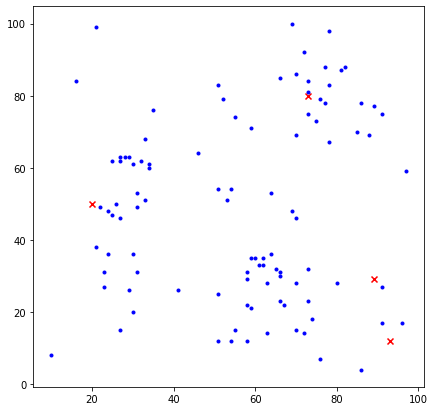

In [4]:
np.random.seed(20)

num_depot = 4
num_cust = 100
num_item = 4
num_vehicle = 20

#-----
# Depot Allocation - Kroger locations
depot_x = [20, 73, 89, 93]
depot_y = [50, 80, 29, 12]


#-----
# Customer Allocation

# random allocations across the grid
cust_x = list(np.random.randint(1, 100, size=15))
cust_y = list(np.random.randint(1, 100, size=15))

# normal distributions in populated household areas
# (28, 47) - (5, 10)
for i in range(25):
    cust_x.append(round(np.random.normal(28, 5)))
    cust_y.append(round(np.random.normal(47, 10)))
    
# (65, 25) - (7, 7)
for i in range(25):
    cust_x.append(round(np.random.normal(65, 7)))
    cust_y.append(round(np.random.normal(25, 7)))

# (80, 70) - (5, 5)
for i in range(25):
    cust_x.append(round(np.random.normal(70, 10)))
    cust_y.append(round(np.random.normal(80, 10)))

# (50, 50) - (20, 20)
for i in range(10):
    cust_x.append(round(np.random.normal(50, 10)))
    cust_y.append(round(np.random.normal(50, 10)))

#-----
# Creating Demands and Vehicle Allocation
np.random.seed(10)
#cust_demand = np.random.randint(5, 15, size=len(cust_x))
cust_demand_item = [np.random.randint(1, 6, size=num_item) for i in range(num_cust)]
weight_item = np.random.randint(1, 4, size=num_item)
cust_demand = cust_demand_item*np.transpose(weight_item)
cust_demand = [sum(cust_demand[i]) for i in range(num_cust)]


#-----
# Plotting attributes
colors = ['blue', 'green', 'orange', 'yellow', 'brown', 'grey']

#-----
# Data Point Verification
print('Range of X -', min(cust_x), ',',max(cust_x), 
      '\nRange of Y -', min(cust_y), ',', max(cust_y))
print('Item weights - ', weight_item)
print('Customer item demands -', cust_demand_item[:4])
print('Customer demands -', cust_demand[:4])

depot_nodes = [[depot_x[i], depot_y[i]] for i in range(len(depot_x))]
print('-----\nDepot Nodes - ', depot_nodes)

# Plotting customer & depot points
plt.scatter(depot_x, depot_y, marker='x', color='r')
plt.scatter(cust_x, cust_y, marker='.', color='b')
plt.show()

#### _____
### Bin Packing - Integer Programming

In [5]:
q_node = cust_demand_item
weight = weight_item
Q = 400

# Bin Packing
b = [0, 0, 0, 0]
for j in range(len(q_node)):
    for i in range(len(weight)):
        b[i] += q_node[j][i]

T = 0
for i in range(num_item):
    T = T + math.ceil(b[i] / math.floor(Q/weight[i]))      # getting an upper limit for the number of vehicles that can be used
print("Number of `place holder' vehicles = "+str(T))

ipmod = Model("Cutting stock IP")
y = ipmod.addVars(range(T),obj=1, vtype=GRB.BINARY,        # these are binary variables indicating
                  name="vehicle_use")                      # whether/not each vehicle is used

z = ipmod.addVars(range(num_item), range(T),               # these are integer variables for the
                  vtype=GRB.INTEGER, name="assignment")    # number of units of each item in each vehicle

# bin packing model
ipmod.modelSense = GRB.MINIMIZE
for j in range(T):
    ipmod.addConstr(quicksum(weight[i]*z[i,j] for i in range(num_item))    # the weight limit constraint for each vehicle
                    - Q*y[j] <= 0, name="vehicle"+str(j))
for i in range(num_item):
    ipmod.addConstr(quicksum(z[i,j] for j in range(T))     # the demand constraint for each item
                    == b[i], name="demand"+str(i))
ipmod.optimize()

print('\n-----\nNumber of vehicles required -', int(ipmod.ObjVal))

Number of `place holder' vehicles = 9
Academic license - for non-commercial use only - expires 2022-09-03
Using license file C:\Users\krishrao\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 13 rows, 45 columns and 81 nonzeros
Model fingerprint: 0x9a0a85c1
Variable types: 0 continuous, 45 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+02, 3e+02]
Found heuristic solution: objective 8.0000000
Presolve time: 0.01s
Presolved: 13 rows, 45 columns, 81 nonzeros
Variable types: 0 continuous, 45 integer (9 binary)

Root relaxation: objective 6.502500e+00, 30 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.50250    0  

_____
### Bin Packing - Column Generation

In [6]:
# Master LP
master = Model("CSP column generation LP")
A = []
s = []
for i in range(num_item):
    s=[0]*num_item
    s[i] = int(Q/weight[i])
    A.append(s)
    
demand = {}
x = {}
for i in range(num_item):
    x[i] = master.addVar(obj=1, vtype=GRB.CONTINUOUS, name="num[%d]"%i)
    # initial patterns for a basic-feasible-solution
    demand[i] = master.addConstr( int(Q/weight[i]) * x[i] >= b[i], name="dem[%d]"%i)
    
n = num_item                            # initially number of patterns equals #items
master.update()
master.setParam("OutputFlag",0)         # turn off output reporting

while 1:
# resolve master LP
    master.optimize()
    profit = [demand[i].Pi for i in range(num_item)]    # optimal dual vars
    
# knapsack instance for the reduced-cost oracle
    kmod = Model("knapsack")
    select = kmod.addVars(range(num_item), vtype=GRB.INTEGER, name="sel")
    kmod.setObjective(quicksum(profit[i]*select[i] for i in range(num_item)), GRB.MAXIMIZE)
    kmod.addConstr(quicksum(weight[i]*select[i] for i in range(num_item)) <= Q, "weight-limit")
    kmod.setParam("OutputFlag",0)       # turn off output reporting
    kmod.optimize()                     # solve knapsack IP
    s= kmod.getAttr('x', select)        # get the optimal knapsack solution (pattern)
#    print(s)

# add column to master LP
    if(kmod.ObjVal < 1.000001): break   # no negative reduced cost

    svalues = [int(s[i]) for i in range(num_item)]
    A.append(svalues)                   # add new column (pattern) to constraint matrix
    
    col = Column()
    for i in range(num_item):
        col.addTerms(s[i], demand[i])        
    x[n] = master.addVar(obj=1, vtype=GRB.CONTINUOUS, name="x[%d]"%n, column=col)
                                   # add the new variable (pattern) to model 
    master.update()   
    n += 1                         # number of decision variables increases
    
xsol = master.getAttr('x', x)    
print(xsol)                        # optimal solution to column-generation LP

print("Optimal value ="+str(master.ObjVal))
print("Final constraint matrix:")
print(np.transpose(np.matrix(A)))

############ Get approximate solution ##############

# Method 1: round-up
apx1 = [math.ceil(xsol[j]) for j in range(n)]
print("Approximate solution (by roundup) has value " + str(sum(apx1[j] for j in range(n))))

# Method 2: re-solve model with integer restrictions on the generated columns/variables
for j in range(n):
    x[j].setAttr("vtype", GRB.INTEGER)  #enforce integer restriction for IP
master.update()
master.optimize()
apx2 = master.getAttr('x', x)
print("Approximate solution (by IP) has value " + str(sum(apx2[j] for j in range(n))))
print("\n-----\nNumber of vehicles required -", int(sum(apx2[j] for j in range(n))))

{0: 0.0, 1: 1.46, 2: 0.6515225563909774, 3: 0.0, 4: 2.308270676691729, 5: 2.082706766917293}
Optimal value =6.5025
Final constraint matrix:
[[133   0   0   0 133   0]
 [  0 200   0   0   0   0]
 [  0   0 400   0   1   1]
 [  0   0   0 133   0 133]]
Approximate solution (by roundup) has value 9
Approximate solution (by IP) has value 9.0

-----
Number of vehicles required - 9


#### _____
### Constrained Vehicle Routing Problem

In [7]:
for l in range(1): #num_depot):
    #depot_x1, depot_y1 = [depot_x[l]], [depot_y[l]]
    num_vehicle = 9
    vehicles = np.array(range(1, num_vehicle+1))
    veh_capacity = [400 for i in range(num_vehicle)]
    veh_depot = [l for i in range(num_vehicle)]
    time_limit = 7200
    vrp_routes, vrp_veh_routes, vrp_node_routes, vrp_X, vrp_Y, vrp_depot, vrp_obj_val = MDCVRP(cust_x, cust_y, cust_demand, 
                                                                                               depot_x, depot_y, vehicles, 
                                                                                               veh_depot, veh_capacity, 
                                                                                               time_limit)

Changed value of parameter timelimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95663 rows, 96508 columns and 750816 nonzeros
Model fingerprint: 0x0c02e2fe
Variable types: 100 continuous, 96408 integer (96408 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 5400 rows and 5400 columns
Presolve time: 0.92s
Presolved: 90263 rows, 91108 columns, 721116 nonzeros
Variable types: 100 continuous, 91008 integer (91008 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.960003e+02, 617 iterations, 0.75 seconds

    Nodes    |    Current Node    |     Objective Bounds   

H 4004  1804                    1436.3477822  508.49155  64.6%  44.8 1072s
  4006  1819  580.90435  182  172 1436.34778  508.49155  64.6%  44.9 1077s
  4023  1855  577.58776  184  177 1436.34778  508.49155  64.6%  45.4 1082s
  4071  1887  577.77377  191  173 1436.34778  508.49155  64.6%  46.3 1088s
  4129  1919  578.70957  201  174 1436.34778  508.49155  64.6%  47.3 1094s
  4199  1955  720.48009  210  175 1436.34778  508.49155  64.6%  48.2 1101s
  4264  2004  579.26882  216  174 1436.34778  508.49155  64.6%  49.2 1108s
  4337  2056  579.36922  223  174 1436.34778  508.49155  64.6%  50.1 1115s
  4425  2101  579.63112  231  177 1436.34778  508.49155  64.6%  50.9 1122s
  4506  2141  579.70141  236  176 1436.34778  508.49155  64.6%  52.3 1130s
  4579  2192  579.87373  244  180 1436.34778  508.49155  64.6%  53.5 1138s
  4666  2258  579.98226  250  177 1436.34778  508.49155  64.6%  54.4 1146s
  4768  2316  580.06299  259  170 1436.34778  508.49155  64.6%  55.4 1154s
  4864  2363  580.19126  

 20761 11368  556.10391   28  200 1361.10391  511.40094  62.4%  50.6 3462s
 20778 11377  560.37724   29  193 1361.10391  511.40094  62.4%  50.6 3466s
 20793 11383  560.50251   30  201 1361.10391  511.40094  62.4%  50.6 3471s
 20807 11391  561.54050   32  200 1361.10391  511.40094  62.4%  50.6 3476s
 20816 11394  570.76487   33  201 1361.10391  511.40094  62.4%  50.6 3480s
 20836 11407  569.67506   35  187 1361.10391  511.40094  62.4%  50.6 3488s
 20846 11411  580.39667   36  180 1361.10391  511.40094  62.4%  50.6 3491s
H20856 10845                    1349.8070496  511.40094  62.1%  50.6 3570s
 20866 10854  594.07856   39  182 1349.80705  511.40094  62.1%  50.6 3577s
 20877 10857  581.61934   40  180 1349.80705  511.40094  62.1%  50.5 3580s
 20899 10871  617.80208   43  177 1349.80705  511.40094  62.1%  50.5 3588s
 20910 10880  605.02934   44  181 1349.80705  511.40094  62.1%  50.5 3593s
 20924 10887  606.29369   46  178 1349.80705  511.40094  62.1%  50.5 3598s
 20941 10892  609.73619  

 33836 11726  574.60437  112  189 1220.65997  512.02739  58.1%  50.6 6539s
 34487 12371  743.37698  263  143 1220.65997  512.02739  58.1%  50.2 6589s
 35144 12826  945.38232  400  130 1220.65997  512.02739  58.1%  49.8 6633s
 35605 12900 1076.95890  493  118 1220.65997  512.02739  58.1%  49.5 6690s
 35679 13285 1077.00287  494  115 1220.65997  512.02739  58.1%  49.5 6735s
 36112 13656  556.88868   89  199 1220.65997  512.02739  58.1%  49.2 6779s
 36509 14084  655.27172  136  188 1220.65997  512.02739  58.1%  49.3 6829s
 37013 14475  571.16812  182  194 1220.65997  512.02739  58.1%  49.4 6871s
 37475 14835  564.62842  215  196 1220.65997  512.02739  58.1%  49.4 6914s
H37946 15003                    1220.5978889  512.02739  58.1%  49.5 6973s
 38133 15288  568.53489  272  196 1220.59789  512.02739  58.1%  49.6 7018s
 38559 15773 1043.42325  347  141 1220.59789  512.02739  58.1%  49.5 7065s
 39094 16274 1043.04854  409  132 1220.59789  512.02739  58.1%  49.3 7108s
 39719 16573 1204.05336  

-----
Overall objective funtion value - 1221


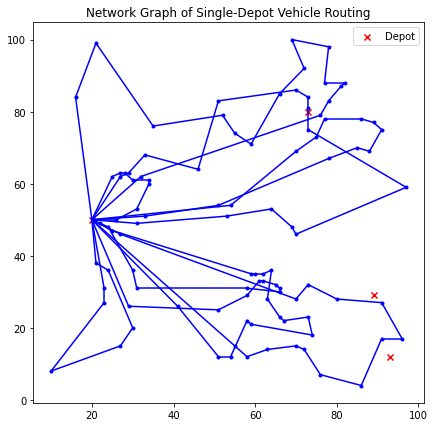

In [8]:
print('-----\nOverall objective funtion value -', vrp_obj_val)
for r in range(len(vrp_routes)):
    for n in range(len(vrp_routes[r])-1):
        i = vrp_routes[r][n]
        j = vrp_routes[r][n+1]
        plt.plot([vrp_X[i], vrp_X[j]], [vrp_Y[i], vrp_Y[j]], color='blue')
plt.scatter(vrp_X[:num_cust], vrp_Y[:num_cust], color='blue', marker='.')
plt.scatter(vrp_X[num_cust:], vrp_Y[num_cust:], color='red', marker='x', label='Depot')
plt.legend()
plt.title('Network Graph of Single-Depot Vehicle Routing')
plt.show()

___
### Constrained Vehicle Routing Problem with Bin Packing

In [9]:
# extra vehicles required 
no_extra = 2

nos = []
for i in range(len(x)):
    nos.append(apx2[i])
veh_capacities = []
for i, n in enumerate(nos):
    if n>0:
        for t in range(int(n+no_extra)):
            veh_capacities.append(A[i])
#veh_capacities
vehicles = [i+1 for i in range(len(veh_capacities))]

In [10]:
veh_capacity = veh_capacities
veh_depot = [0 for i in range(len(vehicles))]
time_limit = 7200
vrp_routes, vrp_veh_routes, vrp_node_routes, vrp_X, vrp_Y, vrp_depot, vrp_obj_val = MDCVRP_BP(cust_x, cust_y, cust_demand_item, 
                                                                                              depot_x, depot_y, vehicles, 
                                                                                              veh_depot, veh_capacity, 
                                                                                              time_limit)

Changed value of parameter timelimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 180519 rows, 182204 columns and 1418208 nonzeros
Model fingerprint: 0x7f716e62
Variable types: 100 continuous, 182104 integer (182104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 10200 rows and 10200 columns
Presolve time: 1.28s
Presolved: 170319 rows, 172004 columns, 1362108 nonzeros
Variable types: 100 continuous, 171904 integer (171904 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.960003e+02, 331 iterations, 0.63 seconds

    Nodes    |    Current Node    |     Objecti

  4791  2854  534.71408   59  184          -  507.99975      -   4.8 1245s
  4881  2886  535.11426   63  184          -  507.99975      -   5.3 1252s
  4928  2901  535.27468   66  180          -  507.99975      -   5.5 1256s
  4981  2915  536.35900   71  181          -  507.99975      -   5.6 1260s
  5074  2947  583.47912   87  175          -  507.99975      -   6.1 1268s
  5129  2954  597.55837   95  166          -  507.99975      -   6.3 1272s
  5183  2975  608.96494  105  166          -  507.99975      -   6.5 1276s
  5255  2985  612.83919  113  166          -  507.99975      -   6.8 1280s
  5312  2998  622.92699  122  163          -  507.99975      -   6.9 1285s
  5456  3024  637.72436  145  154          -  507.99975      -   7.3 1294s
  5542  3032  646.39355  163  157          -  507.99975      -   7.4 1299s
  5622  3044  655.24377  174  157          -  507.99975      -   7.5 1304s
  5715  3089  667.46225  187  154          -  507.99975      -   7.5 1309s
  5819  3110  669.59101  

H20994  9027                    3205.4701901  526.67527  83.6%  16.4 3119s
 20997  9031  526.67527   33  207 3205.47019  526.67527  83.6%  16.4 3127s
 21012  9039  526.85632   35  201 3205.47019  526.78396  83.6%  16.4 3132s
 21019  9044  526.85632   36  201 3205.47019  526.78396  83.6%  16.4 3135s
 21035  9056  535.83896   38  202 3205.47019  526.78396  83.6%  16.4 3140s
 21055  9070  543.86997   40  197 3205.47019  526.78396  83.6%  16.5 3146s
 21067  9070  543.91594   42  194 3205.47019  526.78396  83.6%  16.5 3159s
 21071  9074  544.19449   42  200 3205.47019  526.78396  83.6%  16.5 3163s
 21082  9082  544.57330   43  192 3205.47019  526.78396  83.6%  16.5 3166s
 21108  9087  547.13087   47  190 3205.47019  526.78396  83.6%  16.5 3172s
 21118  9095  547.24964   48  194 3205.47019  526.78396  83.6%  16.5 3176s
 21145  9109  547.45674   51  191 3205.47019  526.78396  83.6%  16.5 3183s
 21161  9117  547.63758   53  191 3205.47019  526.78396  83.6%  16.5 3187s
 21180  9121  555.16308  

 31533  8386  702.96118  720  232 1808.51745  526.81122  70.9%  20.0 5220s
 31805  8575  760.25239  754  225 1808.51745  526.81122  70.9%  20.1 5259s
H32087  8572                    1787.7616340  526.81122  70.5%  20.1 5447s
H32088  8572                    1786.3149287  526.81122  70.5%  20.1 5447s
 32091  8772  767.92948  784  212 1786.31493  526.81122  70.5%  20.1 5495s
 32380  8989  772.22364  821  251 1786.31493  526.81122  70.5%  20.2 5562s
 32623  9218  790.72433  866  187 1786.31493  526.81122  70.5%  20.2 5606s
 32883  9456  801.88578  904  268 1786.31493  526.81122  70.5%  20.2 5647s
 33165  9743  814.11223  945  205 1786.31493  526.81122  70.5%  20.3 5689s
 33483  9982  818.58831  987  170 1786.31493  526.81122  70.5%  20.4 5728s
 33779 10236  820.80700 1013  189 1786.31493  526.81122  70.5%  20.4 5768s
 34089 10474  823.35705 1050  162 1786.31493  526.81122  70.5%  20.4 5803s
H34399 10150                    1677.0192362  526.81122  68.6%  20.5 5922s
H34415  9998             

-----
Overall objective funtion value - 1372


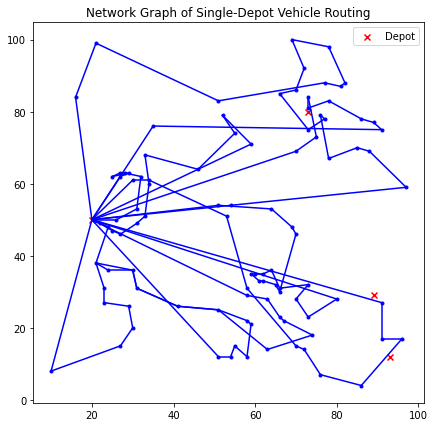

In [11]:
print('-----\nOverall objective funtion value -', vrp_obj_val)
for r in range(len(vrp_routes)):
    for n in range(len(vrp_routes[r])-1):
        i = vrp_routes[r][n]
        j = vrp_routes[r][n+1]
        plt.plot([vrp_X[i], vrp_X[j]], [vrp_Y[i], vrp_Y[j]], color='blue')
plt.scatter(vrp_X[:num_cust], vrp_Y[:num_cust], color='blue', marker='.')
plt.scatter(vrp_X[num_cust:], vrp_Y[num_cust:], color='red', marker='x', label='Depot')
plt.legend()
plt.title('Network Graph of Single-Depot Vehicle Routing')
plt.show()

#### ____
### Multi-Depot Constrianed Vehicle Routing Problem

In [12]:
np.random.seed(4)
num_veh = 9
vehicles = [i for i in range(1, num_veh + 1)]
veh_depot = np.random.randint(0, num_depot, size=num_veh)
veh_capacity = [400 for i in range(num_veh)]

time_limit = 7200
routes, veh_routes, node_routes, X, Y, depot, obj_val =  MDCVRP(cust_x, cust_y, cust_demand, depot_x, 
                                                                depot_y, vehicles, veh_depot, veh_capacity, time_limit)

Changed value of parameter timelimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95663 rows, 96508 columns and 750816 nonzeros
Model fingerprint: 0x8f599fc5
Variable types: 100 continuous, 96408 integer (96408 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 5400 rows and 5400 columns
Presolve time: 0.70s
Presolved: 90263 rows, 91108 columns, 721116 nonzeros
Variable types: 100 continuous, 91008 integer (91008 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 4.926287e+02, 596 iterations, 0.57 seconds

    Nodes    |    Current Node    |     Objective Bounds   

  4479  2650  707.92960  195  155 1257.90817  501.54948  60.1%  36.9  763s
  4593  2726  723.18375  221  142 1257.90817  501.54948  60.1%  37.0  770s
  4709  2790  724.71257  237  142 1257.90817  501.54948  60.1%  36.9  777s
  4817  2811  729.27894  250  138 1257.90817  501.54948  60.1%  37.0  786s
  4894  2854  752.31059  256  148 1257.90817  501.54948  60.1%  37.1  794s
  4984  2867  810.26467  263  139 1257.90817  501.54948  60.1%  37.3  802s
  5042  2916  808.92903  267  160 1257.90817  501.54948  60.1%  37.7  811s
  5130  2952  731.82705  272  153 1257.90817  501.54948  60.1%  38.0  820s
  5228  3019  836.77307  278  138 1257.90817  501.54948  60.1%  38.8  829s
  5340  2995  782.07355  284  142 1257.90817  501.54948  60.1%  39.1  839s
  5360  2997  732.63965  287  150 1257.90817  501.54948  60.1%  39.5  851s
  5372  3010  732.67707  288  150 1257.90817  501.54948  60.1%  39.8  863s
  5404  3019  732.73220  291  150 1257.90817  501.54948  60.1%  40.1  879s
  5428  3033  732.76141  

 30961 24842  962.55711  810  156 1042.96962  501.54948  51.9%  35.8 3692s
H31537 24625                    1027.6405982  501.54948  51.2%  35.7 3812s
 31541 24772  967.20505  957  144 1027.64060  501.54948  51.2%  35.7 3840s
 31721 25219  969.48556 1007  143 1027.64060  501.54948  51.2%  35.7 3876s
 32210 25767  973.54132 1100  140 1027.64060  501.54948  51.2%  35.7 3911s
 32821 26233  717.05143  239  137 1027.64060  501.54948  51.2%  35.6 3940s
 33311 26672  640.22013  130  200 1027.64060  501.54948  51.2%  35.5 4032s
 33847 27167  656.72417  231  170 1027.64060  501.54948  51.2%  35.5 4063s
 34362 27616  759.91657  333  161 1027.64060  501.54948  51.2%  35.3 4093s
 34816 27963  767.81646  436  164 1027.64060  501.54948  51.2%  35.3 4124s
 35197 28382  775.23082  535  160 1027.64060  501.54948  51.2%  35.3 4150s
 35715 28690  988.52567  247  141 1027.64060  501.54948  51.2%  35.3 4176s
 36065 29065  937.52004  275  138 1027.64060  501.54948  51.2%  35.2 4202s
 36618 29523  943.54184  

H75487 61773                     990.8112212  501.54948  49.4%  33.6 7200s

Cutting planes:
  Gomory: 20
  MIR: 57
  Flow cover: 46
  Zero half: 8
  RLT: 2

Explored 75489 nodes (2540902 simplex iterations) in 7200.67 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 990.811 994.333 994.389 ... 1005.99

Time limit reached
Best objective 9.908112212483e+02, best bound 5.015494753705e+02, gap 49.3799%


-----
Overall objective funtion value - 991


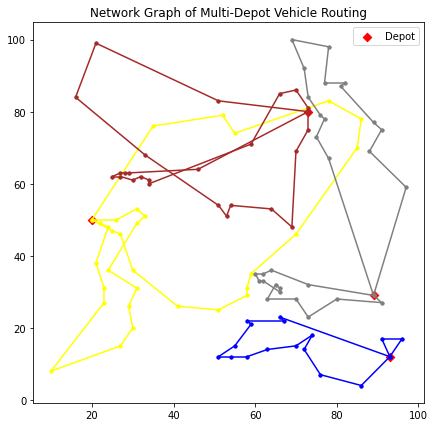

In [13]:
print('-----\nOverall objective funtion value -', obj_val)

X, Y = np.array(X), np.array(Y)
plt.scatter(X[depot],Y[depot],color='red', marker='D', label='Depot')

for r in range(len(routes)):
    color = colors[node_routes[r]]
    for n in range(len(routes[r])-1):
        i=routes[r][n]
        j=routes[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]], color=color, marker='.')

plt.legend()
plt.title('Network Graph of Multi-Depot Vehicle Routing')
plt.show()

____
### Multi-Depot Constrianed Vehicle Routing Problem with Bin Packing

In [14]:
# extra vehicles required 
no_extra = 2
nos = []
for i in range(len(x)):
    nos.append(apx2[i])
veh_capacities = []
for i, n in enumerate(nos):
    if n>0:
        for t in range(int(n+no_extra)):
            veh_capacities.append(A[i])
            
#veh_capacities
vehicles = [i+1 for i in range(len(veh_capacities))]

In [15]:
np.random.seed(20)
veh_capacity = veh_capacities
veh_depot = [np.random.randint(0,4) for i in range(len(vehicles))]
time_limit = 7200

routes, veh_routes, node_routes, X, Y, depot, obj_val =  MDCVRP_BP(cust_x, cust_y, cust_demand_item, depot_x, depot_y, 
                                                                   vehicles, veh_depot, veh_capacity, time_limit)

Changed value of parameter timelimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 180519 rows, 182204 columns and 1418208 nonzeros
Model fingerprint: 0xcdb70511
Variable types: 100 continuous, 182104 integer (182104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 10200 rows and 10200 columns
Presolve time: 1.39s
Presolved: 170319 rows, 172004 columns, 1362108 nonzeros
Variable types: 100 continuous, 171904 integer (171904 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.926287e+02, 387 iterations, 0.61 seconds

    Nodes    |    Current Node    |     Objecti

H 5337  2579                    1848.5865433  522.36790  71.7%  17.3 1429s
  5338  2580  789.61667  319  204 1848.58654  522.36790  71.7%  17.3 1430s
  5340  2581  552.15070   97  209 1848.58654  522.36790  71.7%  17.3 1438s
  5341  2582  522.36790   23  211 1848.58654  522.36790  71.7%  17.3 1441s
  5342  2582 1016.01659  939  219 1848.58654  522.36790  71.7%  17.3 1448s
  5343  2583  587.86516  120  239 1848.58654  522.36790  71.7%  17.3 1451s
  5344  2584  618.45006  186  202 1848.58654  522.36790  71.7%  17.3 1456s
  5345  2584  606.46334  164  202 1848.58654  522.36790  71.7%  17.3 1460s
  5346  2585  659.42205  209  200 1848.58654  522.36790  71.7%  17.3 1466s
  5348  2586  749.62792  289  199 1848.58654  522.36790  71.7%  17.3 1474s
  5349  2587  771.54289  280  212 1848.58654  522.36790  71.7%  17.3 1477s
  5350  2588 1094.03020 1218  203 1848.58654  522.36790  71.7%  17.3 1483s
  5351  2588 1335.56731  983  203 1848.58654  522.36790  71.7%  17.3 1488s
  5352  2589  555.81236  

H 5490   685                    1368.9676995  562.52293  58.9%  38.3 2703s
H 5491   651                    1336.4439442  562.52293  57.9%  38.3 2733s
H 5492   619                    1324.7049865  562.52293  57.5%  38.3 2733s
  5493   620  848.36236  383  211 1324.70499  562.52293  57.5%  38.2 2735s
H 5493   589                    1324.6725750  562.52293  57.5%  38.2 2738s
  5494   589  562.52293   54  207 1324.67258  562.52293  57.5%  38.2 2880s
H 5494   560                    1319.6574312  562.52293  57.4%  38.2 2881s
H 5494   532                    1315.1594152  562.52293  57.2%  38.2 2881s
  5496   534  591.73457  165  220 1315.15942  562.52293  57.2%  38.2 2889s
  5497   534 1169.08187  705  243 1315.15942  562.52293  57.2%  38.2 2893s
  5498   535 1046.73044  993  254 1315.15942  562.52293  57.2%  38.2 2899s
  5499   536  581.11472  115  251 1315.15942  562.52293  57.2%  38.2 2904s
H 5499   509                    1308.0103619  562.52293  57.0%  38.2 2934s
  5501   510  663.00292  

  5684   199  648.68599  207  553 1136.83069  571.33826  49.7%  37.0 3962s
  5685   200  629.51177  250  534 1136.83069  571.33826  49.7%  37.0 3971s
  5689   202  989.69081  497  572 1136.83069  571.34084  49.7%  36.9 3979s
  5690   203 1136.83069  770  560 1136.83069  571.34266  49.7%  36.9 4006s
  5691   204  571.34266   84  573 1136.83069  571.34266  49.7%  36.9 4011s
  5692   204 1072.10072  597  553 1136.83069  571.34266  49.7%  36.9 4019s
  5693   205  848.36236  383  569 1136.83069  571.34266  49.7%  36.9 4024s
  5694   206  571.34266   54  544 1136.83069  571.34266  49.7%  36.9 4034s
  5695   206  793.09488  323  532 1136.83069  571.34266  49.7%  36.9 4038s
  5697   209 1136.83069  705  204 1136.83069  571.34266  49.7%  55.5 4041s
H 5698   199                    1135.9918710  571.34266  49.7%  55.5 4047s
H 5699   189                    1131.4930557  571.34266  49.5%  55.5 4081s
  5702   191  611.81286  182  214 1131.49306  571.34266  49.5%  55.5 4096s
  5704   193  800.98159  

  5878   195  574.06690   73  604 1058.63956  574.06690  45.8%  65.3 5049s
  5879   196 1058.63956  868  585 1058.63956  574.08402  45.8%  65.2 5081s
  5883   198  638.64638  202  660 1058.63956  574.10795  45.8%  65.2 5090s
  5884   199  648.68599  207  641 1058.63956  574.16416  45.8%  65.2 5101s
  5888   202 1058.63956  598  665 1058.63956  574.21964  45.8%  65.1 5109s
  5889   202  989.69081  497  614 1058.63956  574.36668  45.7%  65.1 5157s
  5892   204 1058.63956  597  681 1058.63956  574.37205  45.7%  65.1 5160s
  5896   207  591.73457  165  715 1058.63956  574.39938  45.7%  65.1 5170s
  5897   208 1058.63956  705  627 1058.63956  574.40975  45.7%  65.0 5207s
  5900   210 1019.15687  532  677 1058.63956  574.43738  45.7%  65.0 5210s
  5902   211  611.81286  182  709 1058.63956  574.44384  45.7%  65.0 5218s
  5903   212 1031.77463  987  679 1058.63956  574.45076  45.7%  65.0 5251s
  5907   214  760.51558  263  704 1058.63956  574.57771  45.7%  64.9 5258s
  5908   215  574.60690  

  6442   481  587.35891  132  410 1024.95767  576.57307  43.7%  84.8 6560s
  6482   508  591.73219  135  278 1024.95767  576.57307  43.7%  85.0 6575s
  6516   550  588.50222  139  416 1024.95767  576.57307  43.7%  85.2 6590s
  6558   596  588.04505  144  453 1024.95767  576.57307  43.7%  85.5 6606s
  6604   641  589.62462  148  370 1024.95767  576.57307  43.7%  85.7 6622s
  6649   684  589.82595  151  387 1024.95767  576.57307  43.7%  85.8 6638s
  6693   729  589.82278  155  384 1024.95767  576.57307  43.7%  86.1 6685s
  6741   772  590.76932  159  395 1024.95767  576.57307  43.7%  86.1 6703s
  6785   820  591.46222  163  420 1024.95767  576.57307  43.7%  86.2 6721s
  6834   863  598.08377  167  403 1024.95767  576.57307  43.7%  86.5 6741s
  6880   893  591.84526  172  425 1024.95767  576.57307  43.7%  86.8 6775s
H 6911   893                    1012.7598732  576.57307  43.1%  87.3 6775s
  6912   940  591.99572  176  415 1012.75987  576.57307  43.1%  87.3 6796s
  6959   987  592.23752  

-----
Overall objective funtion value - 1010


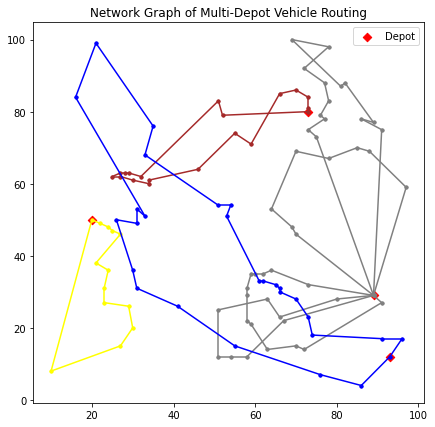

In [16]:
print('-----\nOverall objective funtion value -', obj_val)

X, Y = np.array(X), np.array(Y)
plt.scatter(X[depot],Y[depot],color='red', marker='D', label='Depot')

for r in range(len(routes)):
    color = colors[node_routes[r]]
    for n in range(len(routes[r])-1):
        i=routes[r][n]
        j=routes[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]], color=color, marker='.')

plt.legend()
plt.title('Network Graph of Multi-Depot Vehicle Routing')
plt.show()

#### ____
### Multi-Depot Constrianed Vehicle Routing Problem with k-Means Clustering

-----
Depot Nodes -  [[20, 50], [73, 80], [89, 29], [93, 12]]


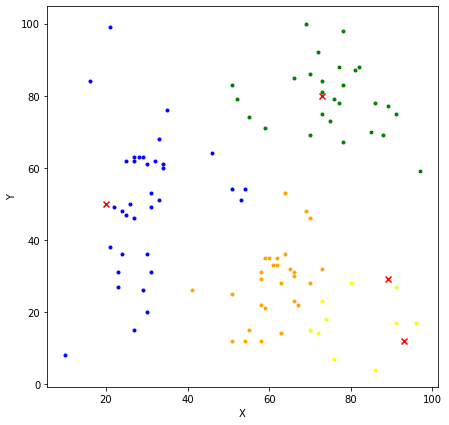

In [17]:
#-----
# Vehicle allocation
np.random.seed(5)
num_vehicle = 12
vehicles = np.array(range(1, num_vehicle+1))
veh_depot = np.random.randint(0, len(depot_x), size=len(vehicles))
depot_nodes = [[depot_x[i], depot_y[i]] for i in range(len(depot_x))]


#-----
# Clustered VRP Problem
cluster = pd.DataFrame(columns=['x', 'y', 'demand'])
cluster['x'] = cust_x
cluster['y'] = cust_y
cluster['demand'] = cust_demand

# Model Initialization
km = KMeans(n_clusters=num_depot, init=np.array(depot_nodes), verbose=0)
#km = MiniBatchKMeans(n_clusters=num_depot, init=np.array(depot_nodes), verbose=0)
cluster['cluster'] = km.fit_predict(cluster[['x', 'y']])

colorz = colors[:len(depot_nodes)]

# Vizualization
for i, color in enumerate(colorz):
    sm_cl = cluster[cluster['cluster']==i]
    plt.scatter(sm_cl.x, sm_cl.y, marker='.', color=color)

print('-----\nDepot Nodes - ', depot_nodes)
plt.scatter(depot_x, depot_y, marker='x', color='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [19]:
#-----
# Running VPR for each cluster
cl_routes, cl_X, cl_Y, cl_obj_val, cl_veh_routes = [], [], [], [], []
colorz = colors[:len(depot_nodes)]
for l, color in enumerate(colorz):
    sm_cl = cluster[cluster['cluster']==l].reset_index(drop=True)
    #A = [(sm_cl.x[i], sm_cl.y[i]) for i in range(sm_cl.shape[0])]
    
    custx = np.array(sm_cl.x)
    custy = np.array(sm_cl.y)
    custd = np.array(sm_cl.demand)
    #depot_x1, depot_y1 = [depot_nodes[l][0]], [depot_nodes[l][1]]
    
    veh = [vehicles[i] for i in range(len(vehicles)) if veh_depot[i]==l]
    veh_dep = [l for i in range(len(veh))]
    veh_cap = [400 for i in range(len(veh))]
    
    #rout, x, y, obj, veh = CVRP(custx, custy, custd, depot, veh, 100)
    time_limit = 1800
    rout, route_veh, rout_dep, x, y, vrp_depot, obj = MDCVRP(custx, custy, custd, depot_x, depot_y, 
                                                                     veh, veh_dep, veh_cap, time_limit)
    cl_routes.append(rout)
    cl_X.append(x)
    cl_Y.append(y)
    cl_obj_val.append(obj)
    cl_veh_routes.append(route_veh)

Changed value of parameter timelimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4396 rows, 4481 columns and 33042 nonzeros
Model fingerprint: 0x9d0b1bbf
Variable types: 35 continuous, 4446 integer (4446 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 630 rows and 630 columns
Presolve time: 0.03s
Presolved: 3766 rows, 3851 columns, 29577 nonzeros
Variable types: 35 continuous, 3816 integer (3816 binary)

Root relaxation: objective 1.881694e+02, 136 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  188.16945    0   71          -  188.16945      -     

 132610 92222  260.82072   66   93  304.18301  240.80958  20.8%  22.4  340s
 135641 94820  271.27290   69   67  304.18301  240.88179  20.8%  22.4  345s
 138821 97314     cutoff   64       304.18301  240.95679  20.8%  22.4  350s
 141927 99846  285.85475  148   34  304.18301  240.99135  20.8%  22.4  355s
 144788 102096  298.71825  161   41  304.18301  241.07182  20.7%  22.4  360s
 147861 104583  259.64844   93   53  304.18301  241.11805  20.7%  22.4  365s
 150682 106811  253.05713   74   44  304.18301  241.17047  20.7%  22.4  370s
 152951 108672  269.14352  256   84  304.18301  241.21196  20.7%  22.4  375s
 155434 110713  288.63068  101   34  304.18301  241.22285  20.7%  22.5  380s
 157549 112643  253.28026  121   86  304.18301  241.25615  20.7%  22.6  385s
 160922 115142  284.45185   87   57  304.18301  241.29781  20.7%  22.6  390s
 164225 117595  274.35023  109   58  304.18301  241.34445  20.7%  22.7  395s
 167126 120149  292.69967  142   37  304.18301  241.37813  20.6%  22.7  400s
 17

 393808 291290  258.26210   93   79  304.18301  244.49986  19.6%  26.8  875s
 396594 293259  267.41076   54   44  304.18301  244.52960  19.6%  26.8  880s
 399398 295475  271.40478   75   45  304.18301  244.56597  19.6%  26.9  885s
 401842 296974  281.45470  107   84  304.18301  244.58547  19.6%  26.9  890s
 404540 298757  272.20160  166   29  304.18301  244.59763  19.6%  26.9  895s
 407163 300684  297.48860  120   51  304.18301  244.61798  19.6%  26.9  900s
 410248 303189  275.01555  203   68  304.18301  244.64406  19.6%  27.0  905s
 412813 304934  262.25426   61  114  304.18301  244.64971  19.6%  27.0  910s
 415301 306707  294.23352  101   52  304.18301  244.66198  19.6%  27.0  915s
 418022 308670 infeasible   85       304.18301  244.68624  19.6%  27.0  920s
 420489 310385  281.20585   70   37  304.18301  244.70588  19.6%  27.1  925s
 423162 312517  267.30090  134   37  304.18301  244.73828  19.5%  27.1  930s
 425687 314329  261.76542   63   62  304.18301  244.76919  19.5%  27.2  935s

 659503 481996  258.17983  185   50  304.18301  246.41553  19.0%  29.3 1410s
 661401 483202  292.67284   84   37  304.18301  246.42885  19.0%  29.3 1415s
 663704 484866  266.77532  137   52  304.18301  246.44520  19.0%  29.3 1420s
 666233 486671  249.77842   57   74  304.18301  246.46132  19.0%  29.3 1425s
 667946 487907  290.18405  131   23  304.18301  246.47069  19.0%  29.3 1430s
 670336 489790  295.55370   53   62  304.18301  246.48554  19.0%  29.3 1435s
 672022 490994  298.57897   87   40  304.18301  246.49318  19.0%  29.3 1440s
 674016 492498  294.72313   93   41  304.18301  246.50434  19.0%  29.3 1445s
 676394 494279  264.59567  121   63  304.18301  246.51884  19.0%  29.3 1450s
 678228 495577  256.11970   72   51  304.18301  246.53698  19.0%  29.3 1455s
 680055 496871  261.37445  113   56  304.18301  246.54160  18.9%  29.4 1460s
 682230 498472  274.81978  239   55  304.18301  246.55172  18.9%  29.4 1465s
 683483 499443  263.40836   78   48  304.18301  246.55930  18.9%  29.4 1470s

H   56    60                     360.6336973  164.33984  54.4%   9.4    0s
H   57    60                     346.7214140  164.33984  52.6%   9.3    0s
*  941   951             279     304.7265227  166.19542  45.5%   7.3    1s
* 1036   985             199     275.5790448  166.19542  39.7%   7.2    1s
H 1318  1198                     275.3531982  166.19542  39.6%   7.4    1s
H 1322  1140                     269.6521843  166.19542  38.4%   7.3    2s
H 1322  1083                     250.2201058  166.19542  33.6%   7.3    2s
H 1323  1030                     246.5442693  166.19542  32.6%   7.3    2s
H 1491  1094                     245.5742645  166.58601  32.2%   9.6    3s
H 1492  1044                     236.6984610  166.58601  29.6%   9.6    3s
H 1499  1006                     236.4910048  166.58601  29.6%   9.6    4s
H 1500   962                     232.2198366  166.58601  28.3%   9.6    4s
H 1501   919                     226.3830951  166.58601  26.4%   9.6    4s
  1972  1218  214.95364  

H10759  6892                     218.4568393  145.14144  33.6%  31.3   54s
 10945  7245  148.26453   43   61  218.45684  145.14354  33.6%  31.3   55s
 12946  8670  146.20250   45  100  218.45684  145.20233  33.5%  31.5   60s
 15555 10609  186.25336   94   43  218.45684  145.30501  33.5%  31.3   65s
 17983 12091  159.13915   58   55  218.45684  145.41758  33.4%  31.0   70s
 19972 13761  179.86973   82   15  218.45684  145.47928  33.4%  31.0   75s
 20461 13762  199.58443   67   56  218.45684  145.48071  33.4%  30.9   90s
H20478 13084                     218.3164644  145.48071  33.4%  30.8   94s
 20480 13086  180.59561   64  125  218.31646  145.48071  33.4%  30.8   95s
 20491 13093  157.87136   68  126  218.31646  145.48071  33.4%  30.8  100s
 20512 13107  147.73854   42  153  218.31646  145.48071  33.4%  30.8  105s
 20529 13118  163.84486   59  194  218.31646  145.48071  33.4%  30.8  110s
 20538 13124  186.98223   71  144  218.31646  145.64455  33.3%  30.7  115s
 20548 13131  145.92305  

 237415 189252  153.16641  132   40  217.00600  147.57232  32.0%  21.9  590s
 239378 191232  174.97492  123   63  217.00600  147.57654  32.0%  21.9  595s
 242522 193788  151.20792   55   57  217.00600  147.58257  32.0%  21.9  600s
 245539 196312  152.76711  195   42  217.00600  147.59116  32.0%  21.8  605s
 247864 197986 infeasible  228       217.00600  147.59328  32.0%  21.8  610s
 249343 199453  151.99243  105   26  217.00600  147.59632  32.0%  21.8  615s
 251988 201776  154.40397  106   31  217.00600  147.59988  32.0%  21.8  620s
 254436 204190  155.84176  103   65  217.00600  147.60423  32.0%  21.8  625s
 257938 207105  156.08044   78   65  217.00600  147.61034  32.0%  21.8  630s
 260362 209038  150.63415   80   27  217.00600  147.61496  32.0%  21.8  635s
H261089 209692                     217.0059765  147.61524  32.0%  21.8  637s
 262870 211227  214.50686  139   50  217.00598  147.61825  32.0%  21.8  640s
 266108 214127  153.83122  123   40  217.00598  147.62523  32.0%  21.7  645s

 505660 419229  176.11351  166   30  217.00580  148.02107  31.8%  20.3 1080s
 507737 420885  153.65124   86   59  217.00580  148.02440  31.8%  20.3 1085s
 510818 423584     cutoff  148       217.00580  148.02833  31.8%  20.3 1090s
 513642 425809  148.20559   55   54  217.00580  148.03267  31.8%  20.3 1095s
 514772 426957  152.93334  170   27  217.00580  148.03422  31.8%  20.3 1100s
 517454 429277  152.46810   56   76  217.00580  148.03665  31.8%  20.3 1105s
 520933 432039  195.06019  116   16  217.00580  148.04021  31.8%  20.3 1110s
 522309 433775  154.41316   96   15  217.00580  148.04238  31.8%  20.3 1115s
 526734 436973  179.16467   92   23  217.00580  148.04872  31.8%  20.2 1120s
 529891 439848  171.57730   90   35  217.00580  148.05511  31.8%  20.2 1125s
 533136 442494  155.60811  134   28  217.00580  148.06086  31.8%  20.2 1130s
 535823 444608  169.46075   93   36  217.00580  148.06337  31.8%  20.2 1135s
 538275 446691  159.15555   98   19  217.00580  148.06669  31.8%  20.2 1140s

 789004 659117  199.36753  102   31  217.00580  148.36274  31.6%  19.9 1620s
 792235 661388  155.68297  120   34  217.00580  148.36444  31.6%  19.9 1625s
 794764 663584  158.75958  188   51  217.00580  148.36733  31.6%  19.9 1630s
 796557 665278  157.22685  143   21  217.00580  148.36857  31.6%  19.9 1635s
 798722 667286  152.18054   97   50  217.00580  148.36981  31.6%  19.9 1640s
 801087 669015  156.68957   96   19  217.00580  148.37169  31.6%  19.9 1645s
 804010 671827  185.70882  221   27  217.00580  148.37389  31.6%  19.9 1651s
 806260 673375  154.30244   54   62  217.00580  148.37605  31.6%  19.9 1655s
 808476 675496  161.88463  137   46  217.00580  148.37813  31.6%  19.9 1660s
 811606 678029  166.28187   97   31  217.00580  148.37957  31.6%  19.8 1665s
 813861 680243  169.52702  243   26  217.00580  148.38129  31.6%  19.8 1670s
 815768 681861  182.89595   88   35  217.00580  148.38405  31.6%  19.8 1675s
 817909 683362  159.14678   91   46  217.00580  148.38613  31.6%  19.9 1680s

-----
Sum of overall objective funtion value - 790


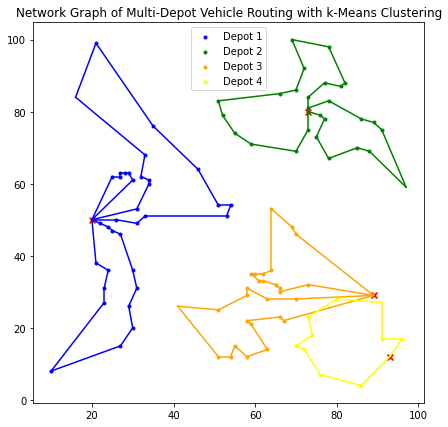

Depot Nodes -  [[20, 50], [73, 80], [89, 29], [93, 12]]


In [20]:

#-----
# Plotting results of Clustered VRP
print('-----\nSum of overall objective funtion value -', sum(cl_obj_val))
for l, color in enumerate(colorz):
    for r in range(len(cl_routes[l])):
        for n in range(len(cl_routes[l][r])-1):
            i = cl_routes[l][r][n]
            j = cl_routes[l][r][n+1]
            plt.plot([cl_X[l][i], cl_X[l][j]], [cl_Y[l][i], cl_Y[l][j]], color=color)
    plt.scatter(cl_X[l][1:], cl_Y[l][1:], color=color, marker='.', label='Depot '+str(l+1))
#plt.scatter(cl_X[l][0], cl_Y[l][0], color='red', marker='x')
plt.scatter(depot_x, depot_y, marker='x', color='r')
plt.legend()
plt.title('Network Graph of Multi-Depot Vehicle Routing with k-Means Clustering')
plt.show()
print('Depot Nodes - ', depot_nodes)

#### _____
### References

* https://stats.stackexchange.com/questions/109547/k-means-vs-k-median
* https://stackoverflow.com/questions/38355153/initial-centroids-for-scikit-learn-kmeans-clustering